In [ ]:
# 1. 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 2. YOLOv8 설치
!pip install ultralytics -q

# 3. 라이브러리 임포트
import os
import glob
import json
import shutil
import zipfile
import random
import yaml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from ultralytics import YOLO

print("환경 설정 완료!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
환경 설정 완료!


In [ ]:
# --- 설정 변수 (이 부분만 수정하세요) ---
# 드라이브에 업로드된 파일 경로 (이미지에 보이는 이름 그대로)
base_path = "/content/drive/MyDrive/mistfarm_data"
zip_label_path = os.path.join(base_path, "TL_A.화초_3.습생식물_08.보스턴고사리.zip")
zip_source_path = os.path.join(base_path, "TS_A.화초_3.습생식물_08.보스턴고사리.zip")

# [중요] 학습에 사용할 이미지 개수 (테스트용으로 500장만 설정)
# 코랩 무료 버전이면 1000장 이상 넘기지 마세요.
SAMPLE_COUNT = 500

# 임시 저장소 경로
dataset_root = "/content/datasets/mistfarm"
temp_label_dir = "/content/temp_labels"   # JSON 풀 곳
temp_image_dir = "/content/temp_images"   # 이미지 풀 곳

# 초기화 (폴더 생성)
for p in [dataset_root, temp_label_dir, temp_image_dir]:
    if os.path.exists(p): shutil.rmtree(p)
    os.makedirs(p, exist_ok=True)

print(f"1. 라벨 데이터(TL) 압축 해제 중... ({zip_label_path})")
# 라벨은 용량이 작으니(38MB) 다 풀어도 됩니다.
with zipfile.ZipFile(zip_label_path, 'r') as zip_ref:
    zip_ref.extractall(temp_label_dir)

print(f"2. 원천 데이터(TS)에서 {SAMPLE_COUNT}장만 추출 중... (시간이 좀 걸립니다)")
# 이미지는 용량이 크니(81GB) 샘플링해서 풉니다.
extracted_images = []
with zipfile.ZipFile(zip_source_path, 'r') as zip_ref:
    # 전체 파일 목록 가져오기
    all_files = [f for f in zip_ref.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # 랜덤하게 샘플링
    if len(all_files) > SAMPLE_COUNT:
        sample_files = random.sample(all_files, SAMPLE_COUNT)
    else:
        sample_files = all_files

    # 추출
    for file in tqdm(sample_files):
        zip_ref.extract(file, temp_image_dir)
        extracted_images.append(os.path.basename(file))

print(f"총 {len(extracted_images)}장의 이미지를 준비했습니다.")

1. 라벨 데이터(TL) 압축 해제 중... (/content/drive/MyDrive/mistfarm_data/TL_A.화초_3.습생식물_08.보스턴고사리.zip)
2. 원천 데이터(TS)에서 500장만 추출 중... (시간이 좀 걸립니다)


  0%|          | 0/500 [00:00<?, ?it/s]

총 500장의 이미지를 준비했습니다.


데이터 분석을 시작합니다...
매칭된 데이터 쌍: 500개


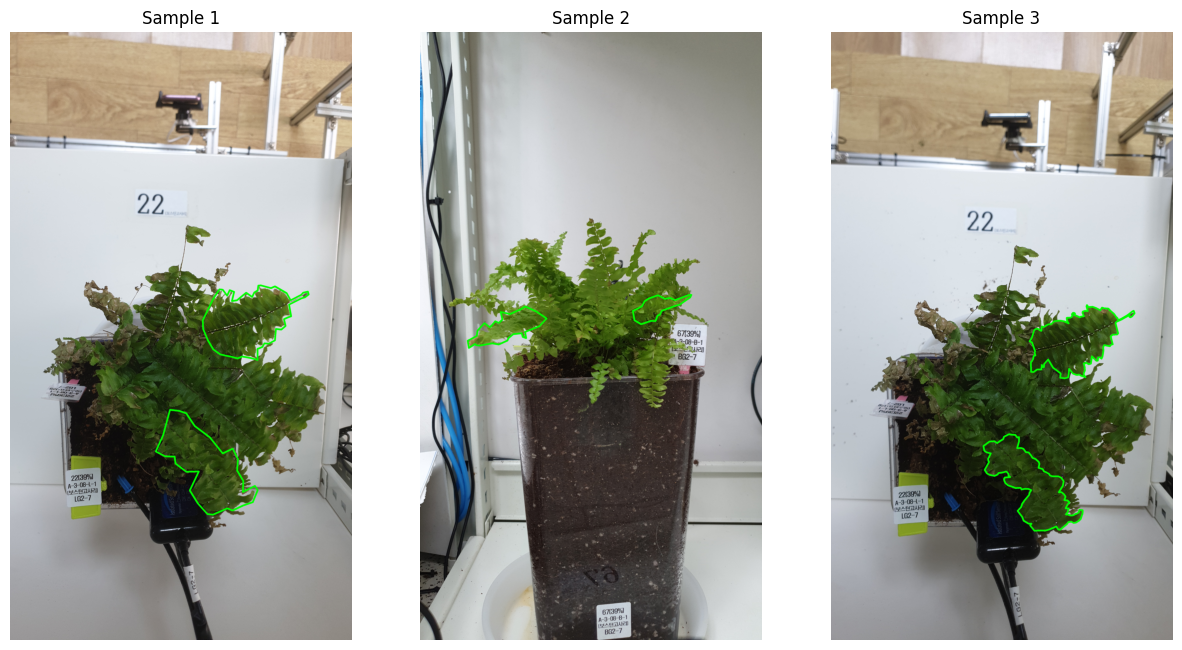

In [ ]:
import os
import glob
import json
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm

# [중요] 2단계에서 설정한 경로와 똑같아야 합니다.
image_dir = "/content/temp_images"
label_dir = "/content/temp_labels"

# 1. JSON 데이터 로드 및 통계 분석
print("데이터 분석을 시작합니다...")
json_files = glob.glob(os.path.join(label_dir, "*.json"))

# 샘플링된 이미지에 해당하는 JSON만 추리기
valid_jsons = []
image_files = set(os.listdir(image_dir)) # 빠른 검색을 위해 set으로 변환

for j_path in json_files:
    # JSON 파일명과 매칭되는 이미지가 있는지 확인
    base_name = os.path.splitext(os.path.basename(j_path))[0]
    # 확장자가 jpg, png, jpeg 중 하나일 수 있음
    if (f"{base_name}.jpg" in image_files) or (f"{base_name}.png" in image_files) or (f"{base_name}.jpeg" in image_files):
        valid_jsons.append(j_path)

print(f"매칭된 데이터 쌍: {len(valid_jsons)}개")

# 2. 랜덤 샘플 시각화 (이미지 위에 초록색 폴리곤 그리기)
import random
samples = random.sample(valid_jsons, min(3, len(valid_jsons)))

plt.figure(figsize=(15, 10))

for idx, j_path in enumerate(samples):
    with open(j_path, 'r') as f:
        data = json.load(f)

    # 이미지 파일 찾기
    img_name = data['picInfo']['ImageName']
    img_path = os.path.join(image_dir, img_name)

    # 만약 파일명이 달라서 못 찾으면, 파일명 규칙으로 다시 찾기
    if not os.path.exists(img_path):
        base_name = os.path.splitext(os.path.basename(j_path))[0]
        # jpg 가정
        img_path = os.path.join(image_dir, base_name + ".jpg")

    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 폴리곤 그리기
        annotations = data.get('annotations', [])
        for ann in annotations:
            points = ann.get('plant_polygon', [])
            if not points: continue

            pts_array = []
            for i in range(0, len(points), 2):
                pts_array.append([int(points[i]), int(points[i+1])])

            pts_np = np.array(pts_array, np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [pts_np], isClosed=True, color=(0, 255, 0), thickness=10) # 초록색, 두께 10

        plt.subplot(1, 3, idx+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {idx+1}")

plt.show()

In [ ]:
# 최종 데이터셋 경로
dataset_root = "/content/datasets/mistfarm"
for split in ['train', 'val']:
    os.makedirs(os.path.join(dataset_root, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_root, split, 'labels'), exist_ok=True)

from sklearn.model_selection import train_test_split
import shutil

# 위에서 찾은 valid_jsons를 Train/Val로 나눔
train_jsons, val_jsons = train_test_split(valid_jsons, test_size=0.1, random_state=42)

def process_advanced(json_list, split):
    print(f"--- {split} 데이터 변환 중 ({len(json_list)}개) ---")
    for j_path in tqdm(json_list):
        try:
            with open(j_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # 1. 이미지 경로 찾기
            base_name = os.path.splitext(os.path.basename(j_path))[0]
            # 우선 jpg로 시도, 없으면 png 등 확인 로직 필요하나 여기선 jpg/png 가정
            img_src = os.path.join(image_dir, base_name + ".jpg")
            if not os.path.exists(img_src):
                img_src = os.path.join(image_dir, base_name + ".png")
                if not os.path.exists(img_src): continue # 이미지 없으면 스킵

            # 2. 이미지 읽어서 크기 확인 (가장 정확)
            img = cv2.imread(img_src)
            if img is None: continue
            h, w, _ = img.shape

            # 3. 라벨 변환 (좌표 보정 포함)
            yolo_lines = []
            annotations = data.get('annotations', [])

            for ann in annotations:
                points = ann.get('plant_polygon', [])
                if len(points) < 6: continue

                normalized_points = []
                for i in range(0, len(points), 2):
                    px, py = float(points[i]), float(points[i+1])

                    # [핵심] 좌표가 이미지 밖으로 나가는 것 방지 (Clipping)
                    px = min(max(px, 0), w)
                    py = min(max(py, 0), h)

                    # 정규화
                    normalized_points.append(f"{px/w:.6f} {py/h:.6f}")

                # 클래스 ID: 0 (단일 클래스)
                # 만약 생장단계별로 나누려면 여기서 data['info']를 보고 class_id를 바꾸면 됩니다.
                class_id = 0
                yolo_lines.append(f"{class_id} {' '.join(normalized_points)}\n")

            # 4. 저장 (라벨이 있는 경우만)
            if yolo_lines:
                # 이미지 복사
                shutil.copy(img_src, os.path.join(dataset_root, split, 'images', os.path.basename(img_src)))
                # txt 저장
                txt_path = os.path.join(dataset_root, split, 'labels', base_name + ".txt")
                with open(txt_path, 'w') as f:
                    f.writelines(yolo_lines)

        except Exception as e:
            print(f"Error: {e}")

# 실행
process_advanced(train_jsons, 'train')
process_advanced(val_jsons, 'val')
print("고급 전처리 완료! 이제 학습(4단계)을 실행하세요.")

--- train 데이터 변환 중 (450개) ---


  0%|          | 0/450 [00:00<?, ?it/s]

--- val 데이터 변환 중 (50개) ---


  0%|          | 0/50 [00:00<?, ?it/s]

고급 전처리 완료! 이제 학습(4단계)을 실행하세요.


In [ ]:
# 1. data.yaml 생성
data_config = {
    'path': dataset_root,
    'train': 'train/images',
    'val': 'val/images',
    'names': {0: 'Boston Fern'} # 보스턴 고사리
}

yaml_path = os.path.join(dataset_root, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_config, f)

# 2. 모델 학습
# 처음엔 500장밖에 없으니 금방 끝납니다. epochs를 20~30 정도로 설정해보세요.
model = YOLO('yolov8n-seg.pt') # nano 모델 (가볍고 빠름)

results = model.train(
    data=yaml_path,
    epochs=20,       # 샘플 데이터라 적게 설정
    imgsz=640,
    batch=8,         # 메모리 안전하게 작게 시작
    project='/content/runs/train',
    name='mistfarm_fern'
)

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/mistfarm/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mistfarm_fern, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0,

In [ ]:
# 학습 결과 드라이브로 백업
import shutil

# 학습 결과가 저장된 경로 (위에서 name='mistfarm_fern'으로 설정함)
source_dir = "/content/runs/train/mistfarm_fern"
dest_dir = "/content/drive/MyDrive/MistFarm_Result/mistfarm_fern"

print("결과물을 구글 드라이브로 복사 중...")
shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)
print(f"복사 완료! 드라이브의 {dest_dir} 폴더를 확인하세요.")
print("best.pt 파일이 Flask 서버에 올릴 모델 파일입니다.")

결과물을 구글 드라이브로 복사 중...
복사 완료! 드라이브의 /content/drive/MyDrive/MistFarm_Result/mistfarm_fern 폴더를 확인하세요.
best.pt 파일이 Flask 서버에 올릴 모델 파일입니다.
